## тут есть обрезание прыжков мыши, показана проблема с 4 мышью

есть функция, измененяющая координаты мыши так, чтобы первая точка была в 0

графики тайм серий x и y

автокорелляция x у всех мышей апрель

автокорелляция фильтрованной скорости и рандома

показано, что мышь 9.2 засела на 1 месте

построены карты оккупации нормализация логарифм, минмах - для всех мышь и усредненная

аналогично построены карты дивергенции для каждой мыши и средняя


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils.processing import (
    open_file,
    cut_jumps,
    df_minmax, 
    open_preprocessed_data
)

### Загрузка траекторий

In [71]:
# Open pre-processed files (or use preproc functions for raw data)
PATH = 'preprocessed_dataset/'
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

df_dict_subtraj = {}
for tr_name in dfs_names:
    tr = open_preprocessed_data(PATH + tr_name + '_orig_dt.pkl')
    df_dict_subtraj[tr_name] = tr

df_dict = {}
for k, df in df_dict_subtraj.items():
    df_dict[k] = pd.concat(df)

## If raw dataset:
# 1. cut_jumps;
# 2. rescale x and y coords to fit area size 
# 3. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
# 4. resample to required dt

#### Пусть первая точка будет (0, 0)

In [72]:
def centralize_starting_point(tr):
    tr['x'] = tr['x'] - tr['x'].iloc[0]
    tr['y'] = tr['y'] - tr['y'].iloc[0]
    return tr
    
cent_df_dict = {}
for k, df in df_dict.items():
    cent_df_dict[k] = centralize_starting_point(df)

### Графики тайм серий x и y

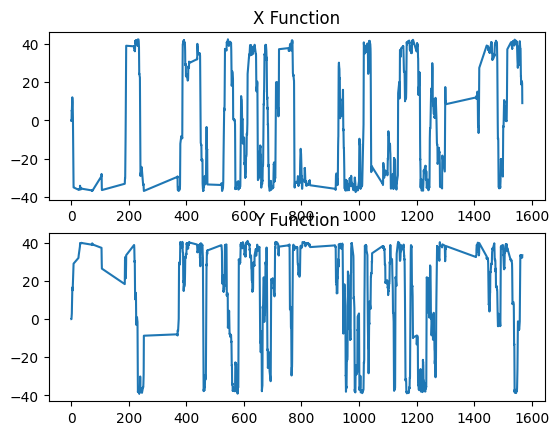

In [73]:
## For 3rd trajectory we can see gaps in trajectory 
df = cent_df_dict['tr3']

figure, axis = plt.subplots(2, 1)
axis[0].plot(df['time'], df['x'])
axis[0].set_title("X Function")
  
# For Cosine Function
axis[1].plot(df['time'], df['y'])
axis[1].set_title("Y Function")
plt.show()

## автокорелляция х у всех мышей апрель

KeyboardInterrupt: 

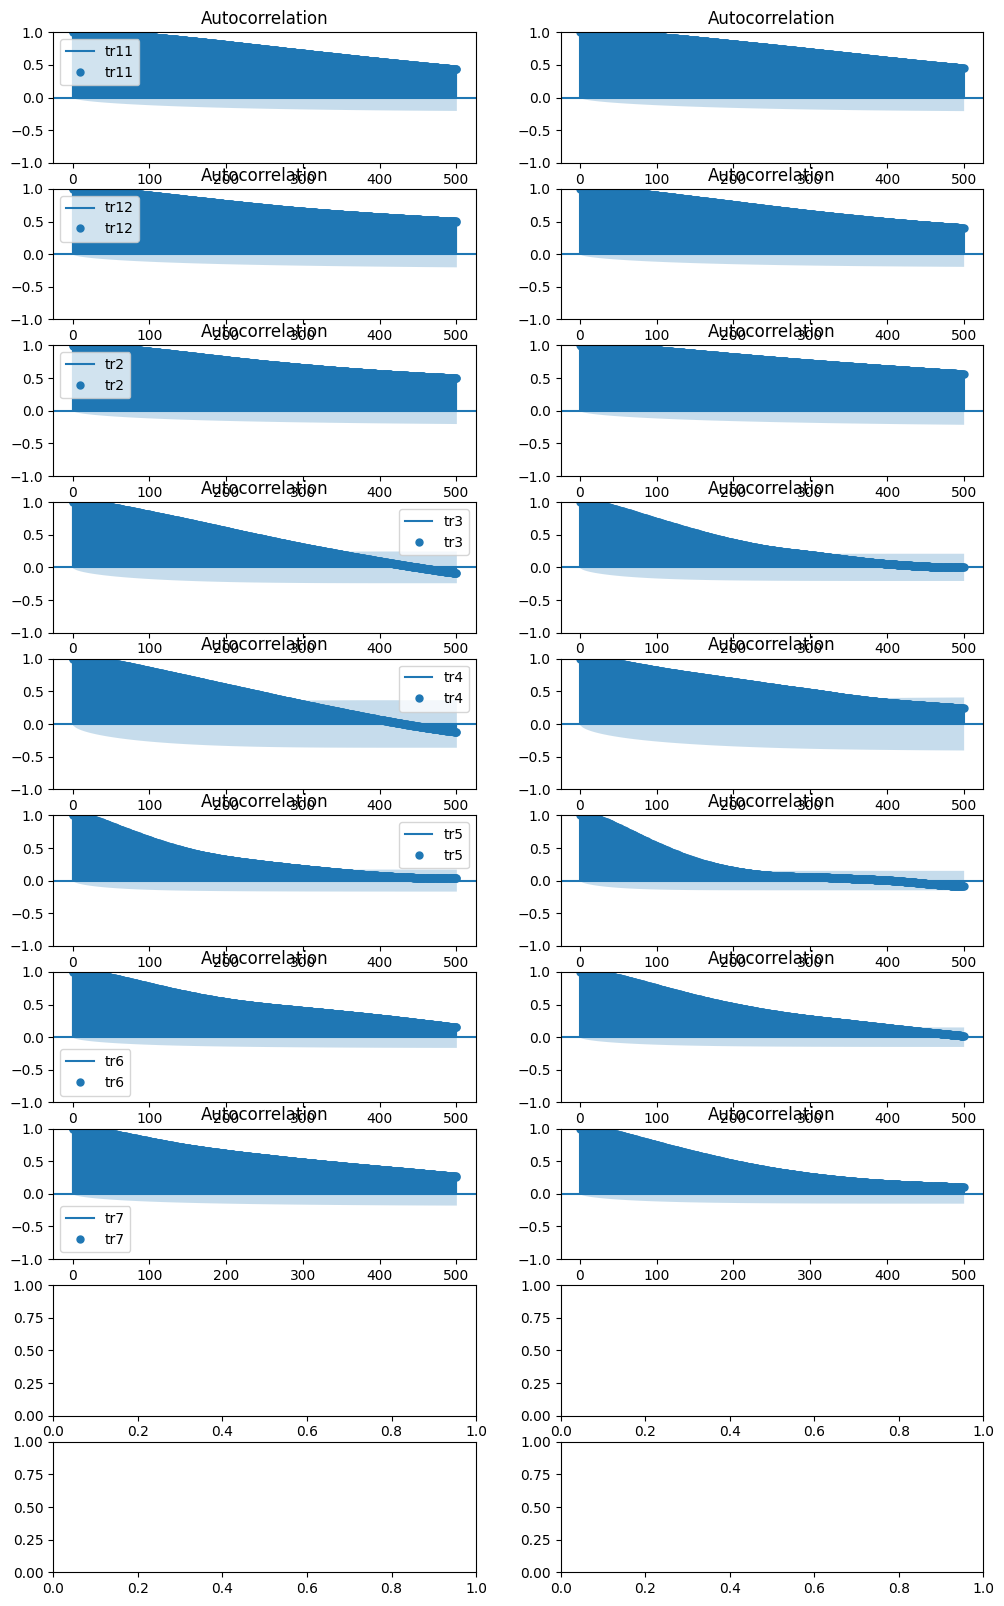

In [74]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# TODO: try different lags!
LAGS_NUM = 500   # TODO: to config

fig, axes = plt.subplots(len(df_dict), 2, figsize=(12, 20))
i = 0
for k, df in df_dict.items():
    if df.shape[0] <= LAGS_NUM:
        continue
    else:
        plot_acf(df['x'].to_numpy(), lags=LAGS_NUM, ax=axes[i, 0], label=k)
        plot_acf(df['y'].to_numpy(), lags=LAGS_NUM, ax=axes[i, 1])
        axes[i, 0].legend()
        i += 1
plt.show()

## NOTE: How to interpret what we have?
# https://www.alpharithms.com/autocorrelation-time-series-python-432909/

## NOTE: Trajectories with gaps should be carefully interpreted! 
# Since acf is time series correlation and trajs with recording gaps  

### acf of filtered Velocity

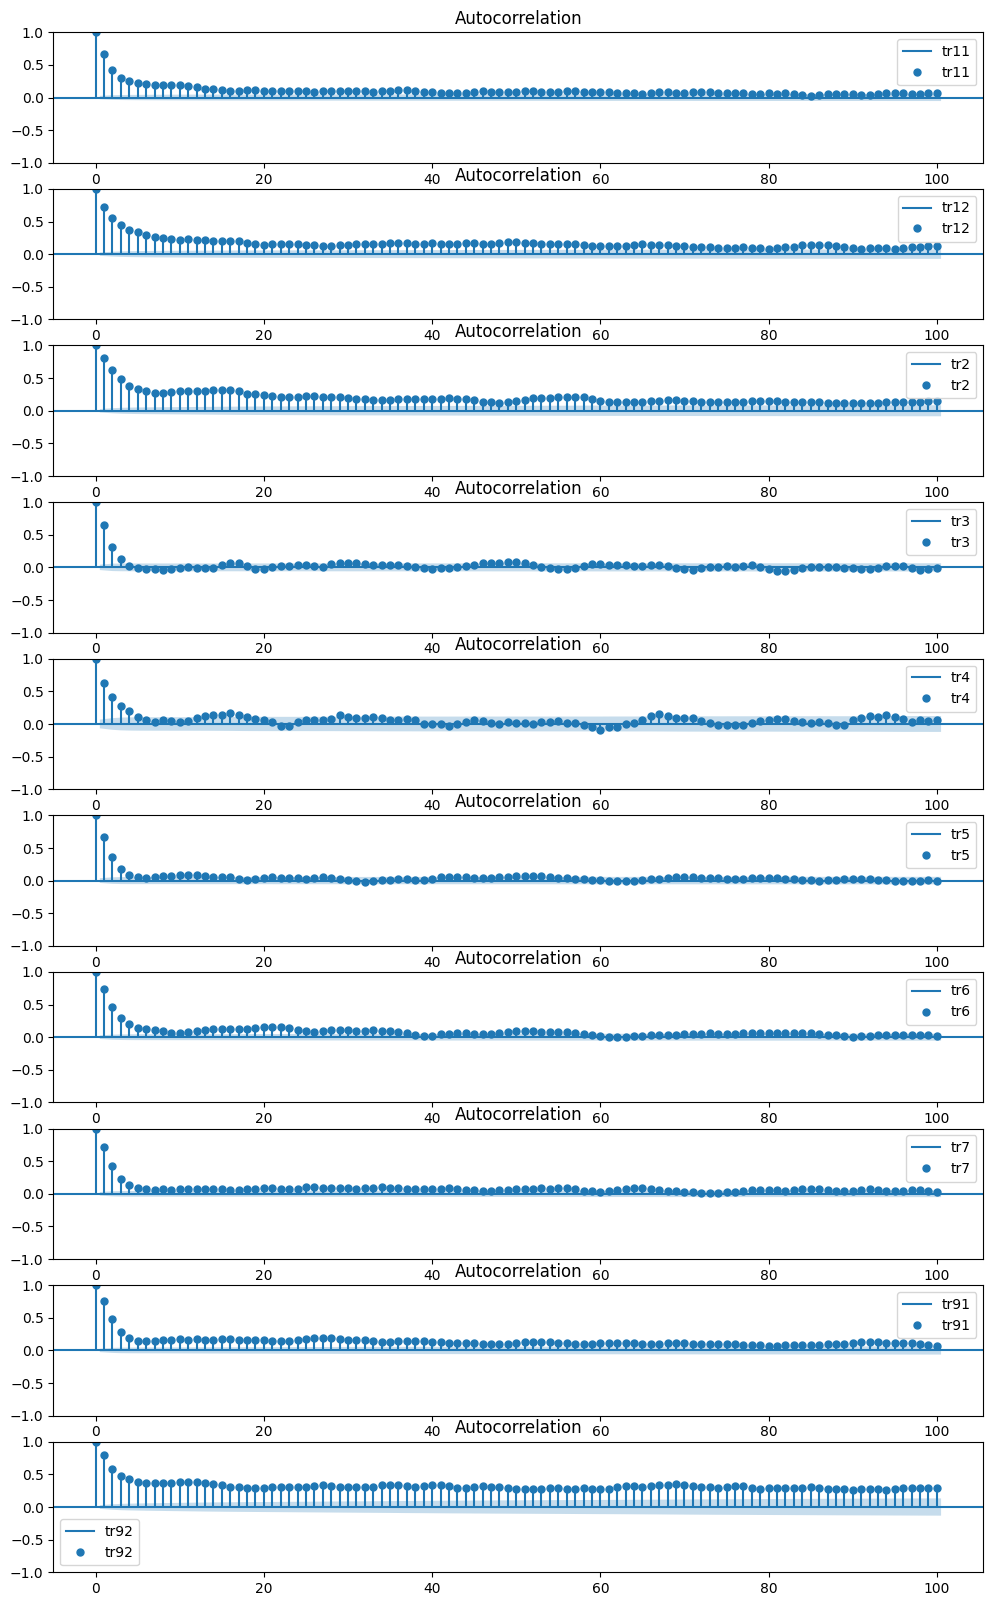

In [10]:
from utils.processing import add_filtered_V

# TODO: try different lags!
LAGS_NUM = 100   # TODO: to config

fig, axes = plt.subplots(len(df_dict), 1, figsize=(12, 20))
i = 0
for k, df in df_dict.items():
    if df.shape[0] <= LAGS_NUM:
        continue
    else:
        df_V = add_filtered_V(df, smooth_kern=None)
        plot_acf(df['V'].to_numpy(), lags=LAGS_NUM, ax=axes[i], label=k)
        axes[i].legend()
        i += 1
plt.show()

## NOTE: How to interpret what we have?
# https://www.alpharithms.com/autocorrelation-time-series-python-432909/

## NOTE: Trajectories with gaps should be carefully interpreted! 
# Since acf is time series correlation and trajs with recording gaps  

#### Строим карты оккупации со шкалой от 0 до 1

In [75]:
def occupMapNorm(df, binn, eps=0.1):
    """ 
    делаем df где будет понятно сколько было точек в каждом бине 
    соответсвуеющему данному интервалу х и данному интервалу у
    """
    xmin = df["x"].min() - eps
    xmax = df["x"].max() + eps
    binx = np.linspace(xmin, xmax, binn)
    x_cut = pd.cut(df.x, binx, right=False)

    ymin = df["y"].min() - eps
    ymax = df["y"].max() + eps
    biny = np.linspace(ymin, ymax, binn)
    y_cut = pd.cut(df.y, biny, right=False)

    dfn = df.groupby([x_cut, y_cut], observed=False).count()
    
    dfn = dfn.drop(columns=['x', 'y'])
    dfn = dfn.rename(columns={'time': 'Count'})
    
    #сделаем df с норм числами в индексах, а не с интервалами
    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))
    
    dd = dfm.unstack()
    arrd = dd.replace(0., 1).to_numpy()
    arrl = np.log(arrd)

    # arrl = df_minmax(arrl)
    return arrl

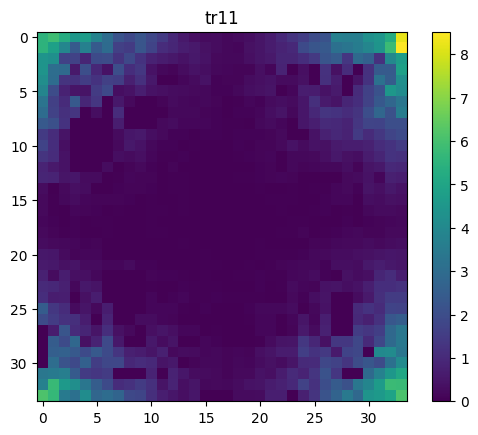

In [111]:
# NOTE: it is better to show gradual measure with gradual color

occ_dict = {}
for k, df in df_dict.items():
    df_copy = df[['time', 'x', 'y']]
    occ = occupMapNorm(df_copy, binn=35)
    occ_dict[k] = occ
    # sns.heatmap(occ, square=True, xticklabels=False,
    #             yticklabels=False, cmap='Blues')
    from scipy.ndimage import gaussian_filter, gaussian_laplace, fourier_gaussian
    occ_s = fourier_gaussian(occ, 0.8, n=-1)
    plt.imshow(occ_s) #interpolation='bilinear', cmap='rainbow')
    plt.title(k)
    plt.colorbar()
    plt.show()
    break

## Average occupancy scores

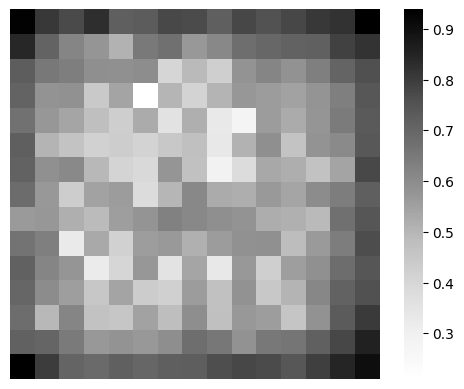

In [91]:
to_average = ['tr3', 'tr5', 'tr6', 'tr7', 'tr91']  # TODO: why these?

mean_occup = []
for k, df in occ_dict.items():
    if k in to_average:
        mean_occup.append(df)
         # блин тут другая ось справа... мб стоит нормализовать. и это странно, среднее значение числел до 1 не мб больше 1

mean_occup = np.asarray(mean_occup)
mean_occup = np.mean(mean_occup, axis=0)

sns.heatmap(mean_occup, square=True, xticklabels=False,
            yticklabels=False, cmap='Grays')
plt.show()

### Divergency all mice

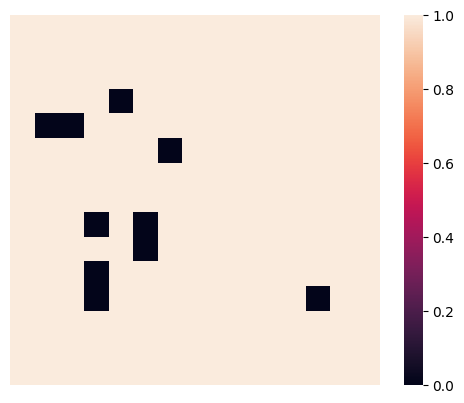

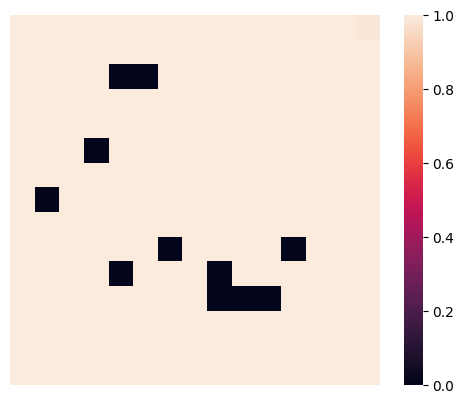

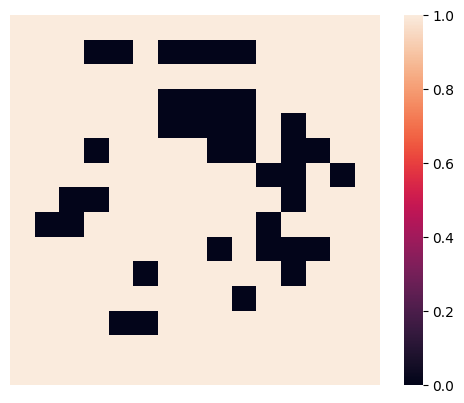

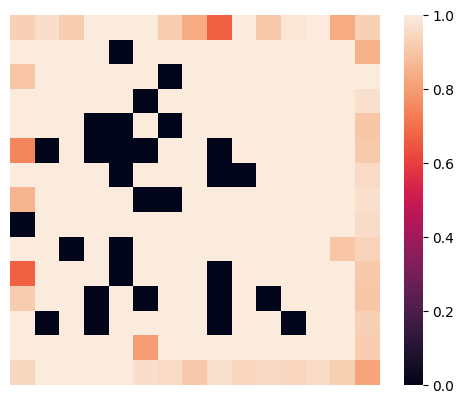

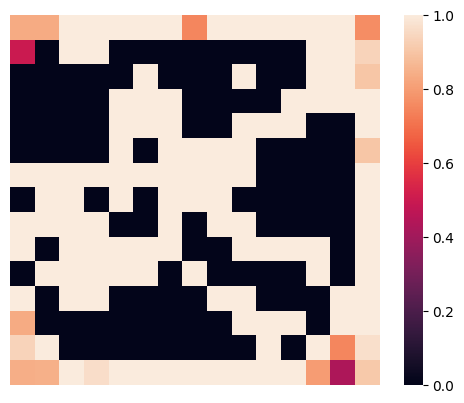

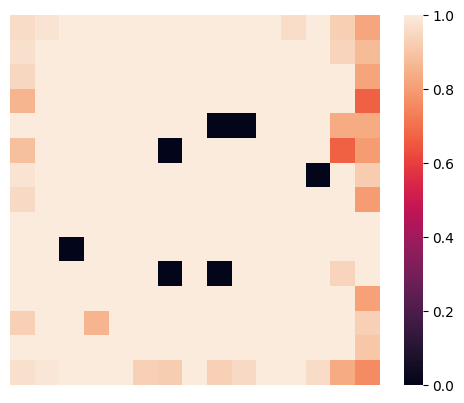

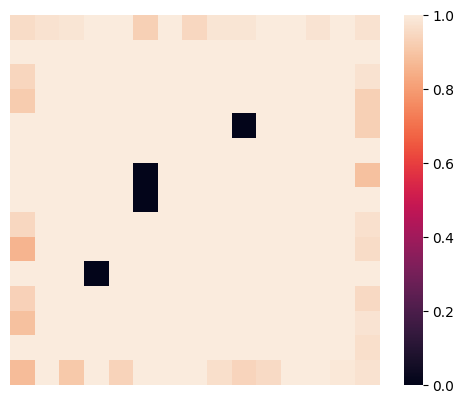

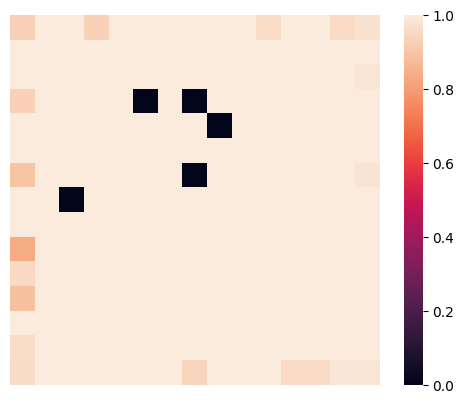

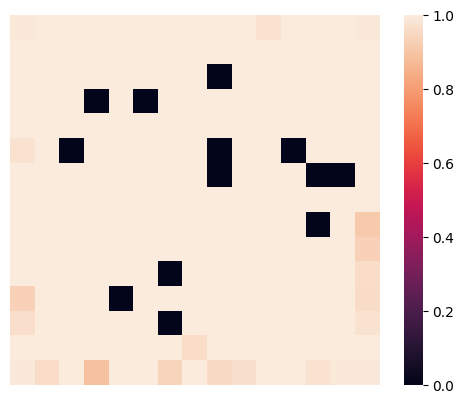

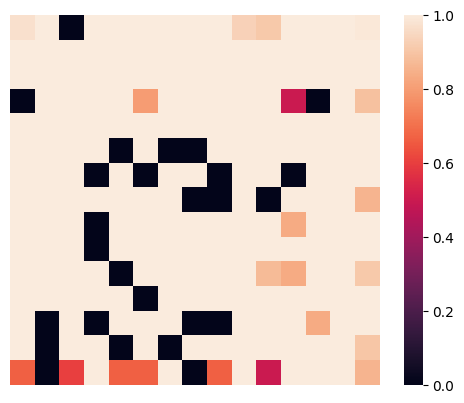

In [96]:
def calc_divergence(df, binn):
    dx, dy = df['x'].diff(), df['y'].diff()
    dx.iloc[0], dy.iloc[0] = 0., 0.

    div = df['Vx']/dx + df['Vy']/dy
    df['divergence'] = div

    binx = np.linspace(df["x"].min(), df["x"].max(), binn)
    x_cut = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min(), df["y"].max(), binn)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut], observed=False).mean()
    dfn = pd.DataFrame(dfn.loc[:, 'divergence'])
    dfn = dfn.unstack()
    dfn = dfn.fillna(0)

    dfn = df_minmax(dfn)
    return dfn


for k, df in df_dict.items():
    df_v = add_filtered_V(df, smooth_kern=None)
    div_map = calc_divergence(df, binn=16)

    sns.heatmap(div_map, robust=False, square=True, xticklabels=False, yticklabels=False)
    plt.show()

In [108]:
def divMap(df, n):
    df = df.reset_index()

    ind = range(0, len(df))
    df = df.reindex(ind)
    vx = []
    vy = []
    div = []
    for i in range(len(df)):
        if i == 0:
            vx.append(0)
            vy.append(0)
            div.append(0)
        elif (df['x'][i]-df['x'][i-1])==0 or (df['y'][i]-df['y'][i-1])==0:
            vx.append((df['x'][i]-df['x'][i-1])/(df['time'][i]-df['time'][i-1]))
            vy.append((df['y'][i]-df['y'][i-1])/(df['time'][i]-df['time'][i-1]))
            div.append(0)
        else:
            dx = df['x'][i]-df['x'][i-1]
            dy = df['y'][i]-df['y'][i-1]
            dt = df['time'][i]-df['time'][i-1]
            vvx = dx/dt
            vvy = dy/dt
            vx.append(vvx)
            vy.append(vvy)
            div.append(vvx/dx + vvy/dy)
    
    df.insert(3, "Vx", vx)
    df.insert(4, "Vy", vy)
    df.insert(5, "divergence", div)
    binx = np.linspace(df["x"].min(), df["x"].max(), n+1)
    x_cut = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min(), df["y"].max(), n+1)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut]).mean()
    dfn = pd.DataFrame(dfn.loc[:, 'divergence'])
    dfn = dfn.unstack()
    #заменим nan на 0
    dfn = dfn.fillna(0)
    #зашьем в керл минмакс
    dfn = df_minmax(dfn)
    sns.heatmap(dfn, robust=False, square=True, xticklabels=False, yticklabels=False)
    plt.show()
    return dfn

/tmp/ipykernel_22244/3728226138.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfn = df.groupby([x_cut, y_cut]).mean()


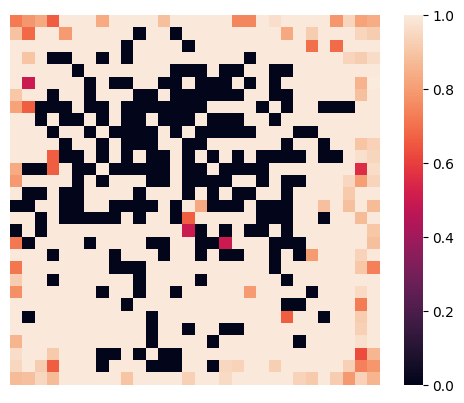

In [114]:
ttt = df_dict['tr7']
ttt_c = ttt[['time', 'x', 'y']]
div3 = divMap(ttt_c, 30)
# div4 = divMap(tr4, 15)
# div5 = divMap(tr5, 15)
# div6 = divMap(tr6, 15)
# div7 = divMap(tr7, 15)
# div9 = divMap(tr9, 15)

<AxesSubplot:>

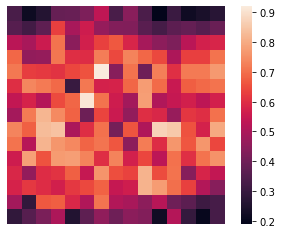

In [79]:
divMean = np.mean( np.array([ div3, div4, div5, div6, div7, div9]), axis=0 )
sns.heatmap(divMean, square=True, xticklabels=False, yticklabels=False)